In [1]:
import torch
import torchvision
from torchvision import transforms
import PIL
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device('cpu')
device

device(type='cuda')

In [24]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.247, 0.243, 0.261))
])

train_set = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1308641].


torch.Size([16, 3, 32, 32]) torch.Size([16])


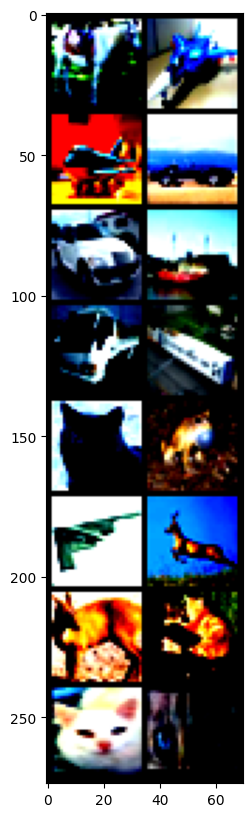

In [26]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)
grid = torchvision.utils.make_grid(images, nrow=2)
grid = grid.permute(1,2,0)

plt.figure(figsize=(10,10))
plt.imshow(grid)

In [5]:
from src.engine.trainer import RectifiedFlowTrainer
from tqdm import tqdm
import itertools
import wandb
from torchinfo import summary
from src.models.rope_dit_modelling import RoPEDiT


In [6]:

def train_loop(trainer, train_loader, num_iter, device, run=None):
    trainer.model.to(device)
    trainer.model.train()

    data_iter = itertools.cycle(train_loader)

    progress_bar = tqdm(range(1, num_iter+1))
    for step in progress_bar:

        images, labels = next(data_iter)
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        loss = trainer.step(images, labels)

        if step%100==0 and (run is not None):
            run.log({
                "loss":loss,
                "step":step
            })

        if num_iter > 10 and step%(num_iter//10) == 0:
            trainer.model.eval()
            torch.save(trainer.model.state_dict(), f"trained/checkpoints/{run.name}_step_{step}_loss_{loss:.4f}.pt")
            trainer.model.train()

        progress_bar.set_description(f"step : {step} | loss : {loss}")

    trainer.model.eval()
    
    if run is not None:
        torch.save(trainer.model.state_dict(), f"trained/{run.name}_final.pt")
        run.finish()


In [15]:
############ hyperparameters #############

model_config = dict(model_dim=256,
                    num_dit_blocks=6,
                    num_attn_heads=8,
                    patch_size=4,
                    num_classes=len(train_set.classes),
                    in_channels=3,
                    use_cfg=True)

learning_rate = 3e-4
drop_prob = 0.2
num_iterations = 5_000
batch_size = 512

##########################################

DiT = RoPEDiT(**model_config)

# print(summary(DiT,
#         input_data=[
#             images,
#             labels,
#             torch.ones_like(labels),
#         ]))
# DiT.compile(fullgraph=True)

optimizer = torch.optim.AdamW(DiT.parameters(), lr=learning_rate)

trainer = RectifiedFlowTrainer(DiT, optimizer, drop_prob)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

run = None

In [8]:
transform

Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)

In [9]:

# run = wandb.init(
#     project="customDiT",
#     entity="divyanshukla",
#     config={
#         "model_config":model_config,
#         "learning_rate":learning_rate,
#         "drop_prob":drop_prob,
#         "num_iterations":num_iterations,
#         "data":{
#                 "dataset":train_set.filename,
#                 "transform":transform,
#                 "batch_size":batch_size,
#                 },
        
#     }
# )

In [10]:
# train_loop(trainer, train_loader, num_iterations, device, run)

In [11]:
# trainer.model.eval()
# torch.save(trainer.model.state_dict(), f"models/{run.name}_final.pt")

In [14]:
del DiT

In [20]:
weights = torch.load(f"trained/playful-aardvark-14_final.pt", map_location=device)
DiT.load_state_dict(weights)  
DiT.eval().to(device)

RoPEDiT(
  (tokenizer): Patchifier(
    (encoder): Sequential(
      (0): Linear(in_features=48, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=48, bias=True)
    )
  )
  (time_embedder): TimestepEmbedder(
    (adapter): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (label_embedder): LabelEmbedder(
    (embedding_table): Embedding(11, 256)
  )
  (dit_blocks): ModuleList(
    (0-5): 6 x DiTBlock(
      (attn): RoPE2DMHA(
        (Wq): Linear(in_features=256, out_features=256, bias=True)
        (Wk): Linear(in_features=256, out_features=256, bias=True)
        (Wv): Linear(in_features=256, out_features=256, bias=True)
        (outproj): Linea

100%|██████████| 100/100 [00:01<00:00, 68.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.111236036..1.2258595].


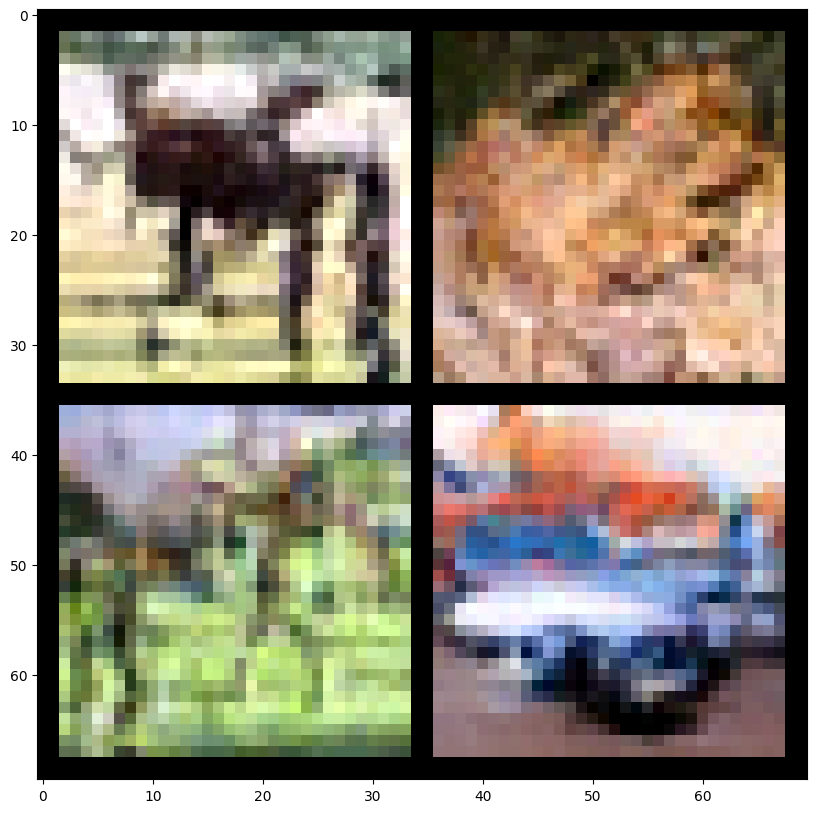

In [21]:
import src.utils.sampler as sampler
from src.utils.sampler import euler_sampler

num_samples = 4

x0 = torch.randn((num_samples, *images.shape[1:]), device=device)
y = torch.randint(len(train_set.classes), size=(num_samples,), device=device)
h = 1e-2
num_steps = int(1/h)
cfg_scale = 3.0

x = euler_sampler(DiT, x0, y, h, num_steps, with_traj=False, cfg_scale=cfg_scale).cpu()

mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(1, -1, 1, 1) 
std = torch.tensor((0.247, 0.243, 0.261)).view(1, -1, 1, 1)

x = x*std + mean

grid = torchvision.utils.make_grid(x, nrow=(num_samples//2))
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(10,10))
plt.imshow(grid)

In [27]:
list(train_set.classes[i] for i in list(y.cpu()))

['horse', 'frog', 'horse', 'automobile']